In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt

Importing PV generation potential and Demand Scenarios

In [2]:
PV_cf = pd.read_csv('dataset/pv_scenario.csv')
PV_cf = PV_cf.drop(columns =['Unnamed: 0'])

In [3]:
Demand_org = pd.read_csv('dataset/demand_scenario.csv')
Demand_org = Demand_org.drop(columns =['Unnamed: 0'])

In [4]:
demand_coeff = 0.08

In [5]:
Demand = Demand_org * demand_coeff

In [6]:
cf_pv = PV_cf.T
demand = Demand.T
probabilities = [0.1, 0.25, 0.4, 0.6, 0.75, 0.9, 1]

In [8]:
time = [*range(cf_pv.shape[0])]
scenario = [*range(cf_pv.shape[1])]

storage = ['BESS']
generator = ['DE']
renewable=['PV']

c_PV_rated = 1 #kW
c_DE_rated = 1000 #kW
c_BESS_rated = 3000 #kWh

pi_D_DE = 0.016 #$/kWh
pi_CO2_DE = 25 #$/t_CO2
phi_CO2_DE = 0.27 #%
teta_eff_DE = 0.31 #%

cf_DE_max = 1
cf_DE_min = 0.2


p_max_CH = 750 #kw 4 hours
p_min_CH = 0 #kw

p_max_DCH = 750 #kw 4 hours
p_min_DCH = 0 #kw

SoC_max = 1
SoC_min = 0.1

eta_CH = 0.90
eta_DCH = 0.90

VoLL = 1000 #$/kWh


PV capacity [Mw] 3.623
DE capacity [Mw] 1.0
BESS capacity [Mwh] 12.0


In [10]:
m = gp.Model()

p_DE = m.addVars(generator, time, scenario, vtype=GRB.CONTINUOUS, name='DEs active power')
p_PV = m.addVars(renewable, time, scenario, vtype=GRB.CONTINUOUS, name='PV active power')
p_CH = m.addVars(storage, time, scenario, vtype=GRB.CONTINUOUS, name='BESS charge')
p_DCH = m.addVars(storage, time, scenario, vtype=GRB.CONTINUOUS, name='BESS discharge')
e_BESS = m.addVars(storage, time, scenario, vtype=GRB.CONTINUOUS, name='BESS energy level')

u_DE = m.addVars(generator, time, scenario, vtype=GRB.BINARY, name='DEs production status')
u_BESS = m.addVars(storage, time, scenario, vtype=GRB.BINARY, name='Charging/Discharging status')

enns = m.addVars(time, scenario, vtype=GRB.CONTINUOUS, name='electricity needed but not supplied')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-19


In [ ]:
n_PV = 3623
n_DE = 1
n_BESS = 4

print('PV capacity [Mw]',n_PV * 1/1000)
print('DE capacity [Mw]',n_DE * 1000/1000)
print('BESS capacity [Mwh]',n_BESS * 3000/1000)

In [11]:
capacity_DE = n_DE * c_DE_rated

power_limit_1 = m.addConstrs(p_DE["DE", t, s] <= capacity_DE * u_DE["DE", t, s] * cf_DE_max
                             for t in time
                             for s in scenario
                             )

power_limit_2 = m.addConstrs(p_DE["DE", t, s] >= capacity_DE * u_DE["DE", t, s] * cf_DE_min
                             for t in time
                             for s in scenario
                             )



#PV

capacity_PV = n_PV * c_PV_rated
capacity_factor_pv = m.addConstrs(p_PV["PV", t, s] == capacity_PV * cf_pv.iloc[t,s]
                                  for t in time
                                  for s in scenario
                                  )

# BESS
capacity_BESS = n_BESS * c_BESS_rated

initial_soc = m.addConstrs(e_BESS['BESS', 0, s] == 0.4 * capacity_BESS for s in scenario)

max_CH_BESS_1 = m.addConstrs(p_CH["BESS", t, s] <= u_BESS ["BESS", t, s] * p_max_CH * n_BESS
                             for t in time
                             for s in scenario
                             )

max_CH_BESS_2 = m.addConstrs(p_CH["BESS", t, s] >= u_BESS ["BESS", t, s] * p_min_CH * n_BESS
                             for t in time
                             for s in scenario
                             )

max_DCH_BESS_1 = m.addConstrs(p_DCH["BESS", t, s] <= (1-u_BESS ["BESS", t, s]) * p_max_DCH * n_BESS
                              for t in time
                              for s in scenario
                              )

max_DCH_BESS_2 = m.addConstrs(p_DCH["BESS", t, s] >= (1-u_BESS ["BESS", t, s]) * p_min_DCH * n_BESS
                              for t in time
                              for s in scenario
                              )

SoC_BESS_1 = m.addConstrs(e_BESS["BESS", t, s] <= capacity_BESS * SoC_max
                          for t in time
                          for s in scenario
                          )

SoC_BESS_2 = m.addConstrs(e_BESS["BESS", t, s] >= capacity_BESS * SoC_min
                          for t in time
                          for s in scenario
                          )

energy_BESS = m.addConstrs(e_BESS["BESS", t, s] == e_BESS["BESS", t-1, s] + (p_CH["BESS", t, s] * eta_CH - p_DCH["BESS", t, s]/eta_DCH)
                           for t in [*range(1,len(time))]
                           for s in scenario
                           )


energy_BESS_constraints = {}
num_days = len(time) // 24
for p in range(1, num_days+1):
    end_hour = p * 24 - 1
    energy_BESS_constraints[p] = m.addConstrs(
        e_BESS["BESS", 0, s] == e_BESS["BESS", end_hour, s] for s in scenario)

meet_demand_1 = m.addConstrs(p_DE['DE', t, s] +
                             p_PV['PV', t, s] +
                             p_DCH['BESS', t, s] +
                             enns[t, s] -
                             p_CH['BESS', t, s] ==
                             demand.iloc[t,s]
                             for t in time
                             for s in scenario
                             )

net_operating_cost = m.setObjective(gp.quicksum(probabilities[s] * (
        (pi_D_DE+pi_CO2_DE/1000*phi_CO2_DE) * (1/teta_eff_DE) * gp.quicksum(p_DE['DE', t, s] for t in time) +
        gp.quicksum(enns[t, s] * VoLL for t in time))
                                                for s in scenario)
                                    , GRB.MINIMIZE)

# m.setParam('OutputFlag', 0)
m.Params.MIPGap = 0.02
m.Params.TimeLimit = 600
m.optimize()

Set parameter MIPGap to value 0.02
Set parameter TimeLimit to value 600
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 22260 rows, 16128 columns and 44499 nonzeros
Model fingerprint: 0xc8f85b0d
Variable types: 12096 continuous, 4032 integer (4032 binary)
Coefficient statistics:
  Matrix range     [9e-01, 3e+03]
  Objective range  [7e-03, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+04]
Presolve removed 22119 rows and 15988 columns
Presolve time: 0.11s
Presolved: 141 rows, 140 columns, 356 nonzeros
Variable types: 92 continuous, 48 integer (48 binary)
Found heuristic solution: objective 7588494.6679

Root relaxation: objective 3.271826e+04, 82 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | 

In [12]:
print(m.objVal)

32718.260527849692


In [ ]:
def plot_scenario(scenario_number, p_DE, p_PV, p_CH, p_DCH, demand):
    # Extract the values of the variables for the chosen scenario
    power_output_DE = np.zeros(len(time))
    charge_BESS = np.zeros(len(time))
    discharge_BESS = np.zeros(len(time))
    energy_BESS =  np.zeros(len(time))

    for t in time:
        power_output_DE[t] = p_DE["DE", t, scenario_number].x

    for t in time:
        charge_BESS[t] = -p_CH["BESS", t, scenario_number].x 
        discharge_BESS[t] = p_DCH["BESS", t, scenario_number].x
        energy_BESS[t] = e_BESS["BESS", t, scenario_number].x

    ENNS = [enns[t, scenario_number].x for t in time]
    power_output_PV = [p_PV["PV", t, scenario_number].x for t in time]

    # Extract the demand values for the chosen scenario
    demand_scenario = [demand.iloc[t,scenario_number] for t in time]  # Assuming time starts from 0

    # Calculate the total power output
    total_power_output = [de + pv + bess for de, pv, bess in zip(power_output_DE, power_output_PV, discharge_BESS)]

    # Calculate the resilience value
    resilience_value = sum(ENNS)
    resilience_value_2 = 1-resilience_value/sum(demand_scenario)

    # Update the time_range to match the total number of hours (48) for the chosen scenario
    time_range = np.arange(len(time))

    # Plot the results
    bar_width = 1
    

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.bar(time_range, power_output_PV, width=bar_width, label='PV', color = 'blue')
    plt.bar(time_range, power_output_DE, width=bar_width, bottom=power_output_PV, label='DE', color = 'orange')

    plt.bar(time_range, discharge_BESS, width=bar_width, bottom=[de + pv for de, pv in zip(power_output_DE, power_output_PV)],
            label='BESS Discharge', color = 'green')
    plt.bar(time_range, charge_BESS, width=bar_width, label='BESS Charge', color = 'red')
    plt.bar(time_range, ENNS, width=bar_width, bottom=total_power_output, label='ENNS', color = 'purple')

    plt.plot(time_range, demand_scenario, 'r--', label='Demand', markersize = 3)
    
    plt.subplot(2, 1, 2)
    plt.plot(time_range, energy_BESS, 'r--', label='Energy BESS', marker = 'o', markersize = 3)
    plt.xticks(range(0,288,24))

    plt.xlabel('Time (hours)')
    plt.ylabel('Power Output (kW)')
    plt.title(f'Scenario {scenario_number}, R={round(resilience_value_2,3)}')
    plt.legend(loc='upper left')
    plt.grid(True)
    # plt.xlim(1, 48)
    # plt.ylim(-3000, 6000)

    # Add resilience value as text annotation
    # plt.text(0.5, 0.9, f'Resilience: {resilience_value_2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    plt.show()
for s in scenario:
    plot_scenario(s, p_DE, p_PV, p_CH, p_DCH, demand)


In [14]:
scenario_number = 13
E_BESS = np.zeros(48)
charge_BESS = np.zeros(48)
discharge_BESS = np.zeros(48)
for t in time:
    E_BESS[t] = sum(e_BESS["BESS", t, b, scenario_number].x for b in index_BESS)
    charge_BESS[t] = sum(-p_CH["BESS", t, b, scenario_number].x for b in index_BESS)
    discharge_BESS[t] = sum(p_DCH["BESS", t, b, scenario_number].x for b in index_BESS)
print(E_BESS)
print(charge_BESS)
print(discharge_BESS)
plt.plot(E_BESS)
plt.show()

NameError: name 'index_BESS' is not defined

In [15]:
E_BESS = np.zeros([len(scenario)])
charge_BESS = np.zeros([len(scenario)])
discharge_BESS = np.zeros([len(scenario)])
PV_production = np.zeros([len(scenario)])
DE_production = np.zeros([len(scenario)])
enns_value = np.zeros([len(scenario)])
demand_value = np.zeros([len(scenario)])
for s in scenario:
    E_BESS[s] = sum(e_BESS["BESS", t, s].x for t in time)
    charge_BESS[s] = sum(p_CH["BESS", t, s].x for t in time)
    discharge_BESS[s] = sum(p_DCH["BESS", t, s].x for t in time)

    PV_production[s] = sum(p_PV["PV", t, s].x for t in time)
    DE_production[s] = sum(p_DE["DE", t, s].x for t in time)
    enns_value[s] = sum(enns[t, s].x for t in time)
    demand_value[s] = demand.iloc[:,s].sum()
    
    

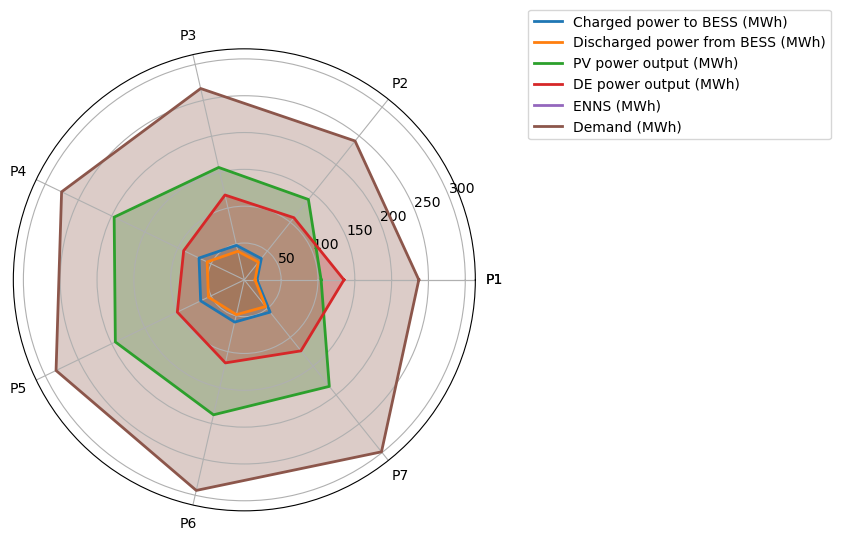

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: Replace these with your actual arrays
data = np.array([
    E_BESS,  # Array 1
    charge_BESS,  # Array 2
    discharge_BESS,  # Array 3
    PV_production,  # Array 4
    DE_production,  # Array 5
    enns_value,  # Array 6
    demand_value   # Array 7
])/1000

# data = np.array([var1, var2, var3, var4, var5, var6, var7])

# Number of variables (rows in your data)
num_vars = data.shape[0]

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop"
# and append the start value to the end.
data = np.concatenate((data, data[:,[0]]), axis=1)
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# ax.plot(angles, data[0, :], linewidth=2, linestyle='solid', label='E_BESS')
ax.plot(angles, data[1, :], linewidth=2, linestyle='solid', label='Charged power to BESS (MWh)')
ax.plot(angles, data[2, :], linewidth=2, linestyle='solid', label='Discharged power from BESS (MWh)')
ax.plot(angles, data[3, :], linewidth=2, linestyle='solid', label='PV power output (MWh)')
ax.plot(angles, data[4, :], linewidth=2, linestyle='solid', label='DE power output (MWh)')
ax.plot(angles, data[5, :], linewidth=2, linestyle='solid', label='ENNS (MWh)')
ax.plot(angles, data[6, :], linewidth=2, linestyle='solid', label='Demand (MWh)')


for i in range(data.shape[1] - 2):
    ax.fill(angles, data[i+1, :], alpha=0.3)

# Add labels for each row/angle
ax.set_thetagrids(np.degrees(angles), labels=['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P1'])

# Add a title and legend
plt.legend(loc='best', bbox_to_anchor=(1.1, 1.1))

plt.show()

In [69]:
p_DE = m.addVars(generator, time, scenario, vtype=GRB.CONTINUOUS, name='DEs active power')
p_PV = m.addVars(renewable, time, scenario, vtype=GRB.CONTINUOUS, name='PV active power')
p_CH = m.addVars(storage, time, scenario, vtype=GRB.CONTINUOUS, name='BESS charge')
p_DCH = m.addVars(storage, time, scenario, vtype=GRB.CONTINUOUS, name='BESS discharge')
e_BESS = m.addVars(storage, time, scenario, vtype=GRB.CONTINUOUS, name='BESS energy level')

u_DE = m.addVars(generator, time, scenario, vtype=GRB.BINARY, name='DEs production status')
u_BESS = m.addVars(storage, time, scenario, vtype=GRB.BINARY, name='Charging/Discharging status')

enns = m.addVars(time, scenario, vtype=GRB.CONTINUOUS, name='electricity needed but not supplied')

241144.15952

In [48]:
def calculate_resilience(demand, enns):
    resilience_values = []
    ENNS_values = []

    for scenario_number in scenario:
        ENNS = [enns[t, scenario_number].x for t in time]
        ENNS_values.append(ENNS)

        # Extract the demand values for the chosen scenario
        demand_scenario = [demand[t][scenario_number] for t in time]

        resilience_value = 1-sum(ENNS)/sum(demand_scenario)

        resilience_values.append(resilience_value)

    average_resilience = np.mean(resilience_values)

    return average_resilience, resilience_values,ENNS_values

average_resilience , resilience_values, ENNS_values= calculate_resilience(demand, enns)

# Print the average resilience value
print(f"Average Resilience: {average_resilience:.6f}")
print(resilience_values)

KeyError: 7

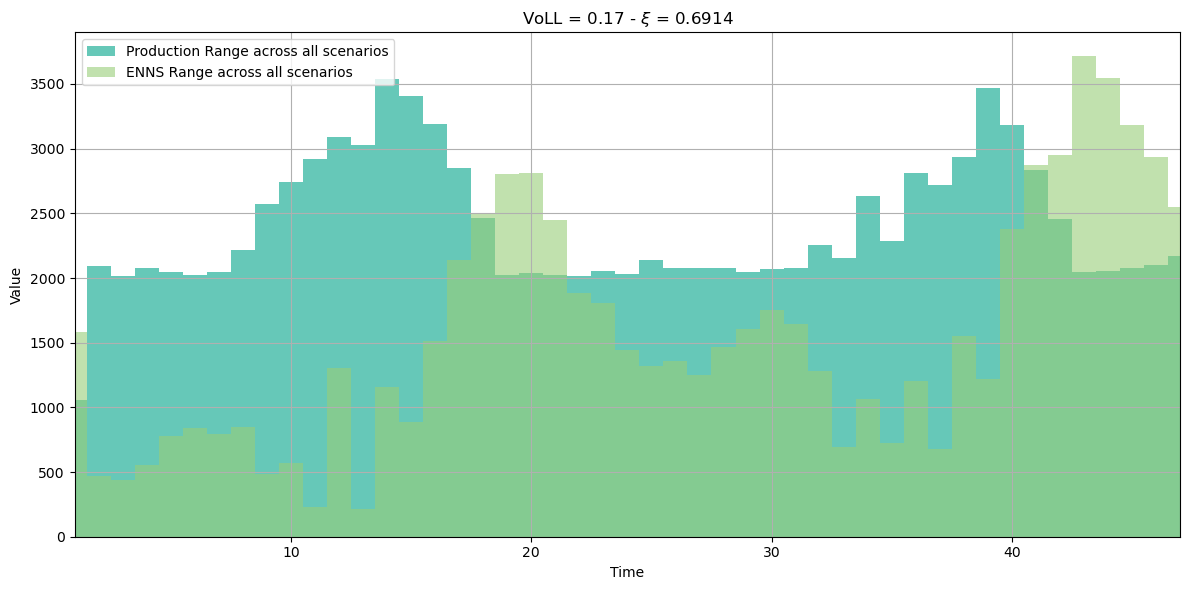

In [40]:
plt.figure(figsize=(12, 6))
# Calculate the maximum and minimum values across all scenarios for each hour
upper_range = {hour: max([demand[hour][scenario] for scenario in range(1, 16)]) for hour in range(48)}
lower_range = {hour: min([demand[hour][scenario] for scenario in range(1, 16)]) for hour in range(48)}
Yellow = (252/255,243/255,110/255,255/255)
# plt.fill_between(range(48),
#                  [0 for hour in range(48)],
#                  [upper_range[hour] for hour in range(48)],
#                  color = Yellow, alpha=1, label='Demand Range across all scenarios', edgecolor ='orange',lw=2)

# Plotting each scenario with reduced alpha
# for scenario in range(1, 16):
#     plt.plot(range(48), [demand[hour][scenario] for hour in range(48)], alpha=0.8, color='gray')

TP_all = []
for s_specific in range(1,16):
    TP_values_per_timestep = {}

    for t in time:
        TP_t = (sum(p_DE['DE', t, g, s_specific].x for g in index_DE) +
                p_PV['PV', t, s_specific].x +
                sum(p_DCH['BESS', t, b, s_specific].x for b in index_BESS) -
                sum(p_CH['BESS', t, b, s_specific].x for b in index_BESS))

        TP_values_per_timestep[t] = TP_t

    # Print the results
    TP_all.append(TP_values_per_timestep)
    # plt.fill_between(range(48), [TP_values_per_timestep[hour] for hour in range(48)],alpha=1)

upper_range_P = {hour: max([TP_all[scenario][hour] for scenario in range(15)]) for hour in range(48)}
lower_range_P = {hour: min([TP_all[scenario][hour] for scenario in range(15)]) for hour in range(48)}
Green = (0/255, 164/255, 137/255, 255/255)
plt.bar(range(48),
                 [upper_range_P[hour] for hour in range(48)],
                 color=Green, alpha=0.6, label='Production Range across all scenarios', edgecolor =None,width=1)

ENNS_ALL = []
for s_specific in range(1,16):
    ENNS_values_per_timestep = {}

    for t in time:
        ENNS_t = enns[t, s_specific].x
        ENNS_values_per_timestep[t] = ENNS_t

    ENNS_ALL.append(ENNS_values_per_timestep)

upper_range_ENNS = {hour: max([ENNS_ALL[scenario][hour] for scenario in range(15)]) for hour in range(48)}
lower_range_ENNS = {hour: min([ENNS_ALL[scenario][hour] for scenario in range(15)]) for hour in range(48)}

Green = (0/255, 164/255, 137/255, 255/255)
plt.bar(range(48),
                 [upper_range_ENNS[hour] for hour in range(48)],
                 color=Green_2, alpha=0.6, label='ENNS Range across all scenarios', edgecolor =None, width = 1)

plt.title(rf"VoLL = 0.17 - $\xi$ = {round(average_resilience,4)}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(loc="upper left")
plt.grid(True)
plt.xlim(1,47)
plt.tight_layout()
plt.show()

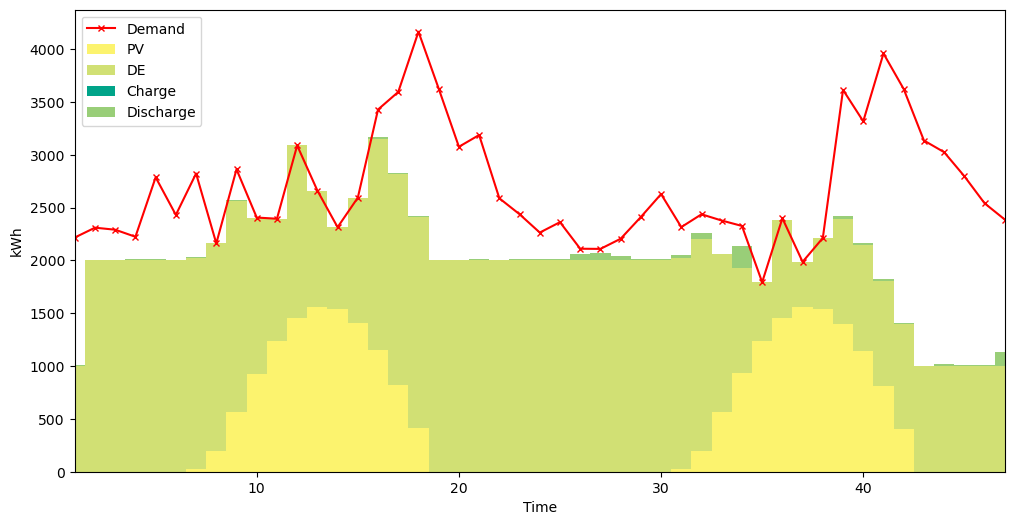

In [14]:
s_specific = 1
TP_DE = []
TP_CH = []
TP_DCH = []
for t in time:
    TP_DE.append(sum(p_DE['DE', t, g, s_specific].x for g in index_DE))
    TP_CH.append(sum(p_CH['BESS', t, b, s_specific].x for b in index_BESS))
    TP_DCH.append(sum(p_DCH['BESS', t, b, s_specific].x for b in index_BESS))
TP_PV = [p_PV['PV', t, s_specific].x  for t in time]

plt.figure(figsize=(12, 6))
# plt.fill_between(range(48),
#                  [TP_PV[hour] for hour in range(48)],
#                  color = Yellow, alpha=1, label='PV Production', edgecolor ='orange',lw=2)
Green = (0/255, 164/255, 137/255, 255/255)
Green_2 = (153/255,206/255,120/255,255/255)
Green_3 = (209/255,224/255,116/255,255/255)
Yellow = (252/255,243/255,110/255,255/255)
plt.bar(range(48),[TP_PV[hour] for hour in range(48)], width=1, label = 'PV', color = Yellow)
plt.bar(range(48),[TP_DE[hour] for hour in range(48)], bottom=[TP_PV[hour] for hour in range(48)], width=1, color = Green_3, label = 'DE')
plt.bar(range(48),[-TP_CH[hour] for hour in range(48)], width=1, label = 'Charge', color = Green)
plt.bar(range(48),[TP_DCH[hour] for hour in range(48)], bottom=[TP_DE[hour] + TP_PV[hour] for hour in range(48)], width=1, color = Green_2, label = 'Discharge')
plt.plot(range(48), [demand[hour][s_specific] for hour in range(48)], color = 'red', marker = 'x', markersize=5, label = 'Demand')
plt.xlim(1,47)
plt.legend()
plt.xlabel('Time')
plt.ylabel('kWh')


plt.show()

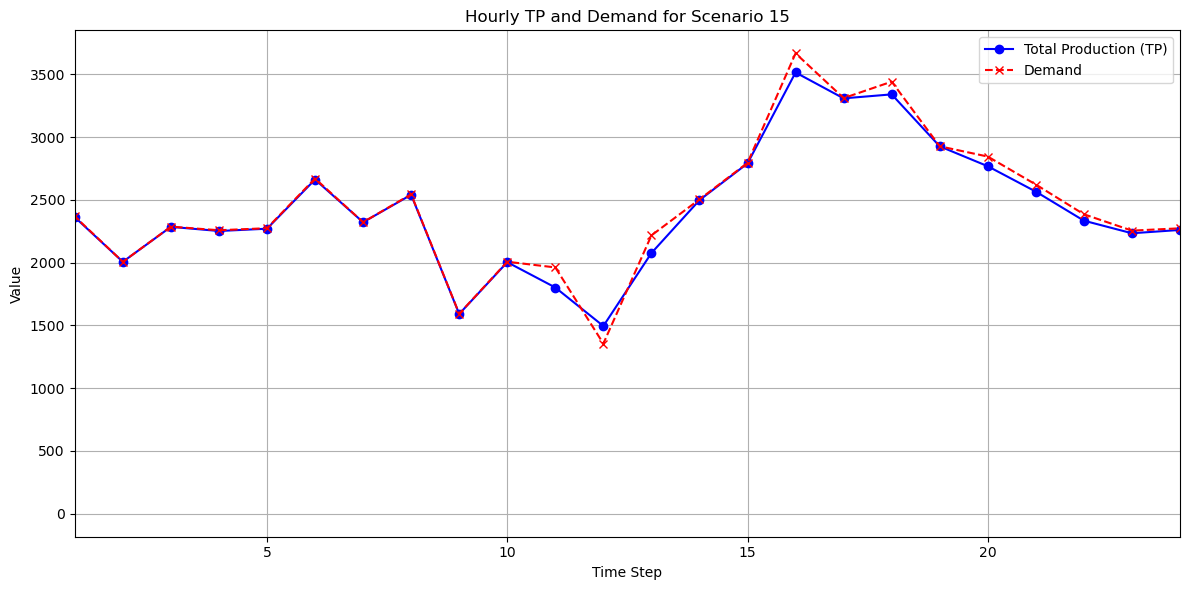

In [62]:
import matplotlib.pyplot as plt

# 1. Extract Data

s_specific = 15 # change this to the specific value of s you're interested in

# Extract TP values for each time step
TP_values = [sum(p_DE['DE', t, g, s_specific].x for g in index_DE) +
             p_PV['PV', t, s_specific].x  for t in time]

# Extract demand values for each time step (assuming you have a decision variable or parameter named 'demand')
demand_values = [demand[t][s_specific] for t in time]
# 2. Plot

plt.figure(figsize=(12, 6))

# Plot TP values
plt.plot(time, TP_values, label='Total Production (TP)', color='blue', marker='o')

# Plot demand values
plt.plot(time, demand_values, label='Demand', color='red', linestyle='--', marker='x')

# Add titles and labels
plt.title(f"Hourly TP and Demand for Scenario {s_specific}")
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.xlim(1,24)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Specify the desired scenario number
desired_scenario = 10

# Create time array for 48 hours
time = np.arange(48)

# Create a plot for DE generator production
plt.figure(figsize=(10, 6))

# Retrieve and plot production for each DE generator
for d in index_DE:
    generator_production = np.zeros(48)

    for t in time:
        generator_production[t] = p_DE['DE', t, d, desired_scenario].X

    # Plot production for the current DE generator
    plt.plot(time, generator_production, label=f'Generator {d}')

# Set labels and title for the plot
plt.xlabel('Time (hours)')
plt.ylabel('Production')
plt.title(f'Production for Each DE Generator (Scenario {desired_scenario})')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


KeyError: ('DE', 25, 1, 10)

<Figure size 1000x600 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Specify the desired scenario number
desired_scenario = 1

# Create time array for 48 hours
time = np.arange(48)

# Retrieve the number of DE generators
num_generators = len(index_DE)

# Create a grid of subplots
fig, axes = plt.subplots(1, num_generators, figsize=(6*num_generators, 6), sharey=True)

# Iterate over each DE generator
for i, d in enumerate(index_DE):
    generator_production = np.zeros(48)

    for t in time:
        generator_production[t] = p_DE['DE', t, d, desired_scenario].X

    # Plot production for the current DE generator in the corresponding subplot
    axes[i].plot(time, generator_production)
    axes[i].set_xlabel('Time (hours)')
    axes[i].set_ylabel(f'Generator {d} Production')

# Set common title for the entire plot
fig.suptitle(f'Production for Each DE Generator (Scenario {desired_scenario})', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
